## Table of Contents:
* [Part 0: Building the network](#part0)
* [Part 1: Network visualization and basic stats](#part1)
* [Part 2: Word-clouds](#part2)
* [Part 3: Communities and TF-IDF](#part3)
* [Part 4: Sentiment of communities](#part4)

# Introduction


The files needed to run the notebook are included in the `assignment2.zip` and are:
1. `edge_list.pickle`: containing the edge list of the network.
2. `zelda_data.csv`: the Zelda dataframe containing the following features for each of the 556 characters:
    1. Name
    2. Role
    3. Race
    4. Text
    5. Preprocessed text
    6. Preprocessed text including bigrams
3. `dialogs.json`: character dialogs for the sentiment analysis in part 4.
4. `pone.0026752.s001.txt`: contains the sentiment dictionary from: https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752#s4

Throughout the notebook, the question we are answering is stated using a yellow backround while everything else should be read as part of our answer.
<div class="alert alert-warning"> This is a question </div>

In [1]:
#Imports
import nltk
from tqdm.notebook import tqdm
import seaborn as sns
from scipy.stats import pearsonr
import re
import pickle
import warnings
import requests
import powerlaw
import networkx as nx
import numpy as np
import pandas as pd
from io import BytesIO
from typing import List
from fa2 import ForceAtlas2
import community
import json
from collections import Counter, namedtuple, defaultdict
from PIL import Image
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import set_matplotlib_formats
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
plt.style.use('science') # Uncomment for final
set_matplotlib_formats('svg')

#Read data
zelda_df = pd.read_csv('zelda_data.csv', index_col=0)
# Converting to the right dtype using eval 
zelda_df.Processed_txt_bigrams = zelda_df.Processed_txt_bigrams.apply(eval)
zelda_df.Processed_txt = zelda_df.Processed_txt.apply(eval)
with open('edge_list.pickle', 'rb') as f:
    edge_list = pickle.load(f)
with open('CharactersDialogue.json', 'r') as f:
    diaglogs = json.load(f)
labmt = pd.read_csv('pone.0026752.s001.txt', sep='\t')
assert len([_ for n1,n2 in edge_list if n1==n2])==0, 'Self referencing nodes in edge-list!'
assert 'Cherry' not in zelda_df['Name'].tolist(), 'fuck...'

<a id='part0'></a>
# Part 0: Building the network 
<div class="alert alert-warning">
To create our network, we downloaded the Zelda Wiki pages for all characters in BotW (during Week 4) and linked them via the hyperlinks connecting pages to each other. To achieve this goal we have used regular expressions!

> * Explain the strategy you have used to extract the hyperlinks from the Wiki-pages, assuming that you have already collected the pages with the Zelda API.
> * Show the regular expression(s) you have built and explain in details how it works.

Our overall strategy for parsing the edges was to make the regex as broad as possible to make sure that we matched all the links and thus captured all possible edges. We then made sure to get unique edges and only keep matches i.e. characters that are in the list of correct characters. This ensures that we don't get any other types of elements from the wikis such as locations or duplicates from the broad search. Each regex have been made to capture the examples in the lab from week 4 as well as tested on examples from the wiki-pages as we have found examples of variations in the text documents e.g. '{{Term/Store|Baddek||Series, BotW}}' which has a different structure than the lab examples. 


In [2]:
# We define a function to parse the edges
def parse_edges(char_page:str, all_chars:list)->list:
    # For direct links
    links = re.findall('{{Term\|BotW\|([a-zA-Z0-9_ ]+)', char_page)
    links = re.findall('\[([a-zA-Z0-9_ ]+)\]\]', char_page)
    # For links using text
    links += re.findall('{{Term\|Series\|([a-zA-Z0-9_ ()]+)', char_page)
    links += re.findall('\[\w+\|([a-zA-Z0-9_ ]+)\]\]', char_page)
    # Plurals
    links += re.findall('{{Plural\|Series\|([a-zA-Z0-9_ ]+)', char_page)
    # Other page sections
    links += re.findall('\[([a-zA-Z0-9_ ]+)#', char_page)
    # A catch all for double square brackets and characters
    links += re.findall('\[\[(.*?)(?:\|.*?)?\]\]', char_page)
    links += re.findall('{{Term\|BotW\|(.*?)(?:\|link.*?|\|display=.*?)?}}', char_page)
    
    #return a list of characters which exists in our predefined characters list
    return list(set([l for l in links if l in all_chars]))

In [3]:
# We create a test string with all examples from the lab to show how it works
test_string = 'there is a[[Baddek]] or maybe a {{Term|BotW|Chabi|link}} we find links using text, i.e. [[Treasure Octorok|Zelda]] or perhaps we find {{Term|Series|Princess Zelda|link|display=Zelda}}. Can we find links to pages that have parentheses, i.e. [[Stone Talus (Luminous)|]] or {{Term|Series|Stone Talus (Senior)|link}} or can we find links using plural terms, i.e. [[Spoone]]s or {{Plural|Series|Stalnox|link}} lastly we want to find links to sections of another page, i.e. [[Link#Breath of the Wild]] or {{Term|BotW|Dinraal|link}}'
all_chars = zelda_df["Name"].tolist() #Characters to find
print(test_string)
print("\n" + '_'*54,'RESULTS','_'*54)
print(parse_edges(test_string, all_chars))

there is a[[Baddek]] or maybe a {{Term|BotW|Chabi|link}} we find links using text, i.e. [[Treasure Octorok|Zelda]] or perhaps we find {{Term|Series|Princess Zelda|link|display=Zelda}}. Can we find links to pages that have parentheses, i.e. [[Stone Talus (Luminous)|]] or {{Term|Series|Stone Talus (Senior)|link}} or can we find links using plural terms, i.e. [[Spoone]]s or {{Plural|Series|Stalnox|link}} lastly we want to find links to sections of another page, i.e. [[Link#Breath of the Wild]] or {{Term|BotW|Dinraal|link}}

______________________________________________________ RESULTS ______________________________________________________
['Dinraal', 'Link', 'Stalnox', 'Baddek', 'Stone Talus (Senior)', 'Stone Talus (Luminous)', 'Spoone', 'Chabi', 'Treasure Octorok', 'Princess Zelda']


The function succeeded in only returning names which occur in the character list as well as extracting parenthesis alongside names which contain them. 

Let's explain in greater detail how they work. To capture characters inside double curly brackets, we used different variations of the following*: 

>  {{Term\|BotW\|([a-zA-Z0-9_ ]+)

The first part looks for a string contains '{{Term' we then use \ to ensure that the | isn't interpreted as an or-operator. In the final part we use parentheses to define what it should return. Inside the square brackets, we look for all alphanumeric characters - both upper- and lowercase. We end it with a plus sign to capture any other character which might occur after. This strategy was repeated for the links which contain 'Series' and 'Plural|Series' rather than 'BotW'. We also included parenthesis inside the brackets to capture character names such as 'Stone Talus (Senior)'. 

To capture characters inside double square brackets, we used variations of this: 

>  \[\[(.*?)(?:\|.*?)?\]\]

Here we again escape the brackets to ensure that it understands that such a bracket pattern should be part of the string. We then have a parenthesis with '.*?' which is greedy and should catch any type of character including '´'. We then have another set of parentheses. Using '?:' we tell it to pass any characters which succeeds the '|'. We end it with a '?' to ensure we didn't miss anything and tell it to stop looking for the sequence, when it meets the other half of the double square brackets. 

In spite of some overlap in the different expressions, we deem them all necessary to ensure that we capture as many as possible. Our strategy captured 1803 edges from the wiki-pages. An alternative - and more naive - strategy would be to simply look for all the character names in text and extract matches without using any regex. This would of course return some false positives, all though we believe it would be a reasonable strategy as well.

*the markdown does not show escape characters - see code cell for exact regex

<a id='part1'></a>
# Part 1: Network visualization and basic stats
<div class="alert alert-warning">
Visualize the network (from lecture 5) and calculate stats (from lecture 4 and 5). For this exercise, we assume that you've already generated the BotW network and extracted the giant connected component. Use the GCC to report the results.

_Exercise 1a_: Stats (see lecture 4 and 5 for more hints)
* What is the number of nodes in the network? 
* What is the number of links?

In [4]:
# Dictionary of attributes
chars_attributes = zelda_df[["Name","Role", "Race", "Gender"]].set_index('Name').to_dict("index")

# Creating graph
G = nx.DiGraph()
G.add_nodes_from(all_chars)
G.add_edges_from(edge_list)
nx.set_node_attributes(G, chars_attributes)
    
# Extracting the Giant component
gcc = max(nx.weakly_connected_components(G), key=len)
gcc = G.subgraph(gcc)

print("There is {} nodes in the network.".format(len(gcc.nodes)))
print("There is {} links in the network.".format(len(gcc.edges())))

There is 535 nodes in the network.
There is 1803 links in the network.


<div class="alert alert-warning">

Who is the top connected character in BotW? (Report results for the in-degrees and out-degrees). Comment on your findings. Is this what you would have expected?

In [5]:
# We add the in- and out-degrees to a dataframe of all characthers and their attributes
zelda_df = zelda_df.merge(pd.DataFrame(gcc.in_degree(), columns = ["Name", "In-degree"]), on = "Name", how = "left")
zelda_df = zelda_df.merge(pd.DataFrame(gcc.out_degree(), columns = ["Name", "Out-degree"]), on = "Name", how = "left")
# Function to get the names 
def get_highdegree_names(col, n = 1, df = zelda_df):
    names = df.sort_values(col, ascending = False)["Name"]
    if n <= 1:
        return names.values[0]
    else: 
        return names.values[0:n].tolist()

print("The most connected-character in terms of in-degrees is {char} with a score of {score}."\
     .format(char = get_highdegree_names("In-degree"),
             score = round(max(zelda_df["In-degree"]))))

print("The most connceted-character in terms of out-degrees is {char} with a score of {score}."\
     .format(char = get_highdegree_names("Out-degree"),
             score = round(max(zelda_df["Out-degree"]))))

The most connected-character in terms of in-degrees is Link with a score of 415.
The most connceted-character in terms of out-degrees is Traysi with a score of 14.


In line with what we would expect *Link* has the highest in-degree. As Link is the main character of the game appearing in all series it is not surprising that most other characters link to Link (lol) in their page.
 
Without context-knowledge of BotW it is more difficult to assess why *Traysi* is the character with the highest out-degree. However, inspecting the character-page it becomes clear that Traysi is an investigative journalist, why her page contains a high amount of links to other characters that she has interviewed.


<div class="alert alert-warning">

* Who are the top 5 most connected allies (again in terms of in/out-degree)? 
* Who are the top 5 most connected enemies -- bosses included -- (again in terms of in/out-degree)?

In [6]:
def top_5_degrees(degree, Role):
    if Role == "Ally":
        top_5_degree_names = zelda_df\
                                .sort_values(degree, ascending = False)\
                                .loc[zelda_df["Role"] == "Ally"]\
                                .head(5)["Name"]\
                                .values
        top_5_degree_values = zelda_df\
                                .sort_values(degree, ascending = False)\
                                .loc[zelda_df["Role"] == "Ally"]\
                                .head(5)[degree]\
                                .values        
    else: 
        top_5_degree_names = zelda_df\
                                .sort_values(degree, ascending = False)\
                                .loc[zelda_df["Role"] != "Ally"]\
                                .head(5)["Name"]\
                                .values
        top_5_degree_values = zelda_df\
                                .sort_values(degree, ascending = False)\
                                .loc[zelda_df["Role"] != "Ally"]\
                                .head(5)[degree]\
                                .values
    
    return top_5_degree_names, top_5_degree_values

In [7]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

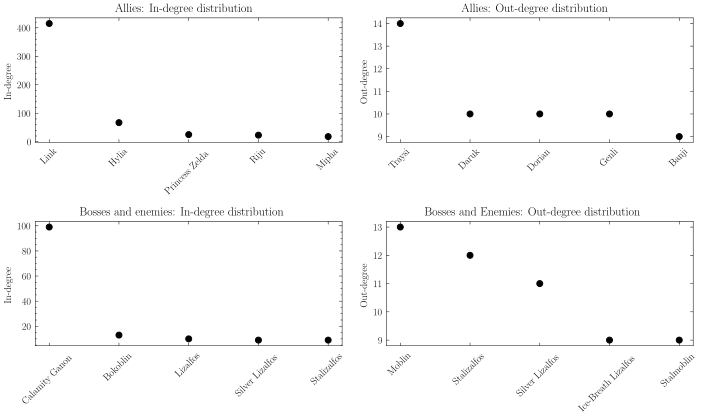

In [8]:
# We define four subplots
fig, axs = plt.subplots(2, 2, dpi = 120, figsize = (10,6))
# Ignore warning :)
warnings.filterwarnings("ignore")

# In-degree distributions (Allies)
x,y = top_5_degrees("In-degree", "Ally")
axs[0][0].plot(x, y, 'ko')
axs[0][0].set_ylabel('In-degree')
axs[0][0].set_xlabel('')
axs[0][0].set_xticks(x)
axs[0][0].set_xticklabels(x, rotation = 45)
axs[0][0].set_title('Allies: In-degree distribution')
axs[0][0].tick_params(axis='x', which='minor', bottom=False, top=False)


# In-degree distributions (Bosses and Enemies)
x,y = top_5_degrees("In-degree", "Others")
axs[1][0].plot(x, y, 'ko')
axs[1][0].set_ylabel('In-degree')
axs[1][0].set_xlabel('')
axs[1][0].set_xticklabels(x, rotation = 45)
axs[1][0].set_title('Bosses and enemies: In-degree distribution')
axs[1][0].tick_params(axis='x', which='minor', bottom=False, top=False)

# Out-degree distributions (Allies)
x,y = top_5_degrees("Out-degree", "Ally")
axs[0][1].plot(x, y, 'ko')
axs[0][1].set_ylabel('Out-degree')
axs[0][1].set_xlabel('')
axs[0][1].set_xticklabels(x, rotation = 45)
axs[0][1].set_title('Allies: Out-degree distribution')
axs[0][1].minorticks_off()

# Out-degree distributions (Bosses and Enemies)
x,y = top_5_degrees("Out-degree", "Others")
axs[1][1].plot(x, y, 'ko')
axs[1][1].set_ylabel('Out-degree')
axs[1][1].set_xlabel('')
axs[1][1].set_xticklabels(x, rotation = 45)
axs[1][1].set_title('Bosses and Enemies: Out-degree distribution')
axs[1][1].minorticks_off()

plt.tight_layout()

<div class="alert alert-warning">

* Plot the in- and out-degree distributions.
* What do you observe? 
* Can you explain why the in-degree distribution is different from the out-degree distribution?

In [9]:
# We define a function that counts the encounters of the different degrees
def sorted_lists(col):
    counters = sorted(Counter(zelda_df.loc[zelda_df[col].notna()][col]).items())
    x = [i[0] for i in counters]
    y = [i[1] for i in counters]    
    return x, y

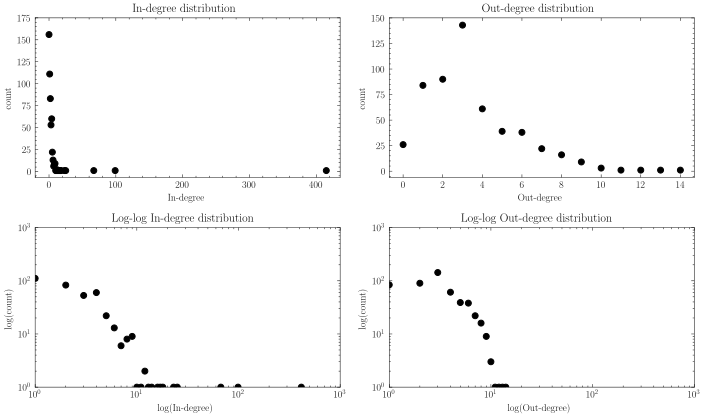

In [10]:
# We define four subplots
fig, axs = plt.subplots(2, 2, dpi = 120, figsize = (10,6))

# In-degree distributions
x,y = sorted_lists("In-degree")
axs[0][0].plot(x, y, 'ko')
axs[0][0].set_yticks(range(0, max(y)+25, 25))
axs[0][0].set_ylabel('count')
axs[0][0].set_xlabel('In-degree')
axs[0][0].set_title('In-degree distribution')

# And the log plot
axs[1][0].plot(x, y, 'ko')
axs[1][0].loglog()
axs[1][0].set_xlim(1e0, 1e3)
axs[1][0].set_ylim(1e0, max(y)+100)
axs[1][0].set_yticks([1e0, 1e1, 1e2, 1e3])
axs[1][0].set_ylabel('$\log($count$)$')
axs[1][0].set_xlabel('$\log($In-degree$)$')
axs[1][0].set_title('Log-log In-degree distribution')

# Out-degree distributions
x,y = sorted_lists("Out-degree")
axs[0][1].plot(x, y, 'ko')
axs[0][1].set_yticks(range(0, max(y)+25, 25))
axs[0][1].set_ylabel('count')
axs[0][1].set_xlabel('Out-degree')
axs[0][1].set_title('Out-degree distribution')
axs[0][1].tick_params(axis='x', which='minor', bottom=False, top=False)


# And the log plot
axs[1][1].plot(x, y, 'ko')
axs[1][1].loglog()
axs[1][1].set_xlim(1e0, 1e3)
axs[1][1].set_ylim(1e0, max(y)+100)
axs[1][1].set_yticks([1e0, 1e1, 1e2, 1e3])
axs[1][1].set_ylabel('$\log($count$)$')
axs[1][1].set_xlabel('$\log($Out-degree$)$')
axs[1][1].set_title('Log-log Out-degree distribution')

plt.tight_layout()

We answer both questions in this cell as the answers overlap quite a bit. At first glance when looking at the raw distributions there seems to be quite a difference in the in-degree and out-degree distributions. However, when plotted to a log-log scale these differences shrink. The reason for this is that the in-degree distribution there is a few nodes considerably higher than the rest suggesting the network to have scale-free properties (Barabási, 2016). Link, the character with the by far highest in-degree, is a good example of this: Almost every other page links to him Although the number of links on his own page is not as proportionally high.

<div class="alert alert-warning">

Find the exponent of the degree distribution (by using the `powerlaw` package) for the in- and out-degree distribution. What does it say about our network?

In [11]:
%%capture
# We extract the the exponent
in_degree_dist = zelda_df.loc[zelda_df["In-degree"].notna()]["In-degree"].values
out_degree_dist = zelda_df.loc[zelda_df["Out-degree"].notna()]["Out-degree"].values
in_degree_exp = powerlaw.Fit(in_degree_dist)
out_degree_exp = powerlaw.Fit(out_degree_dist)

In [12]:
print("The exponent of the In-degree distribution is: {}"\
      .format(in_degree_exp.power_law.alpha))
print("The exponent of the Out-degree distribution is: {}"\
      .format(out_degree_exp.power_law.alpha))

The exponent of the In-degree distribution is: 3.0304610265604266
The exponent of the Out-degree distribution is: 10.913309058436411


As our network is directed, we know that the probability of a random character to point another character $k_{out}$ is given by $Pk_{out}\sim$ $k^{-\gamma_{in}}$ and the probability of a random character to be linked to $k_{in}$ is given by $Pk_{in} \sim$ $k^{-\gamma_{out}}$, where $\gamma$ is the exponent of the degree distribution (Barabási, 2016). In other words are $k_{out}$ and $k_{in}$ not nesercarilly the same. We saw this before in the degree-distributions and the calculations of the exponents supports it as well: Due to power-law distributions, the probability for a random character to be linked to is smaller than the probability of it linking to another character. This suggests that the network's in-degree distribution to a larger extent than the out-degree distribution has scale-free properties (Barabási, 2016).

<div class="alert alert-warning">

Compare the degree distribution of the undirected graph to a *random network* with the same number of nodes and probability of connection *p*. Comment your results.

Before we compare the degree distributions we need to find $p$ for the random network. As we know for a random undirected network that $p = \frac{\langle k \rangle}{(N-1)}$ we utilize that ${\langle k \rangle} = \frac{2L}{N}$ to find $p$ (Barabási, 2016).

In [13]:
# We change the network from directed to undirected
gcc = nx.DiGraph.to_undirected(gcc)

# We set n and k
n = len(gcc.nodes())
k = (2*len(gcc.edges()))/n
p = k/(n-1)

# We create the undirected network
G_r = nx.gnp_random_graph(n = n, p = p, seed = 42)

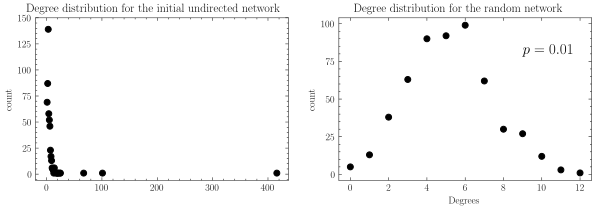

In [14]:
# Function to extract x and y
def get_degrees_list(g):
    counters = sorted(Counter([x[1] for x in g.degree()]).items())
    return [i[0] for i in counters], [i[1] for i in counters]

# We define four subplots
fig, axs = plt.subplots(ncols = 2, dpi = 120, figsize = (10,3))

# Initial network
x,y = get_degrees_list(gcc)
axs[0].plot(x, y, 'ko')
axs[0].set_yticks(range(0, max(y)+25, 25))
axs[0].set_ylabel('count')
axs[0].set_xlabel('')
axs[0].set_title('Degree distribution for the initial undirected network')

# Random network
x,y = get_degrees_list(G_r)
axs[1].plot(x, y, 'ko')
axs[1].set_yticks(range(0, max(y)+25, 25))
axs[1].set_ylabel('count')
axs[1].set_xlabel('Degrees')
axs[1].set_title('Degree distribution for the random network')
axs[1].tick_params(axis='x', which='minor', bottom=False, top=False)
axs[1].annotate(f'$p ={round(p, 2)}$',xy=(9,80), size=15)
plt.show();

The two plots illustrate that we are working with two different types of networks: One with scale-free properties and a random network. Whereas the degrees in our initial undirected network of Zelda characters follows a power distribution, the degrees in the random network follows a gaussian distribution. This highlights an important difference in scale-free and random networks: The formation of hubs. While we have seen several times how few characters seem to dominate the Zelda network, this is clearly not the case for the random network, where all nodes have the same linking probability.

<div class="alert alert-warning">

_Exercise 1b_: Visualization (see lecture 5 for more hints)

> * Create a nice visualization of the total (undirected) network:
>   * Color nodes according to the role;
>   * Scale node-size according to degree;
>   * Get node positions based on the Force Atlas 2 algorithm;
>   * Whatever else you feel like that would make the visualization nicer.

In [15]:
# We create a ForceAtlas2 object
forceatlas2 = ForceAtlas2(gravity=1)
positions = forceatlas2.forceatlas2_networkx_layout(gcc, pos=None, iterations=2000)

100%|██████████| 2000/2000 [00:06<00:00, 314.71it/s]

BarnesHut Approximation  took  1.70  seconds
Repulsion forces  took  4.06  seconds
Gravitational forces  took  0.06  seconds
Attraction forces  took  0.04  seconds
AdjustSpeedAndApplyForces step  took  0.26  seconds


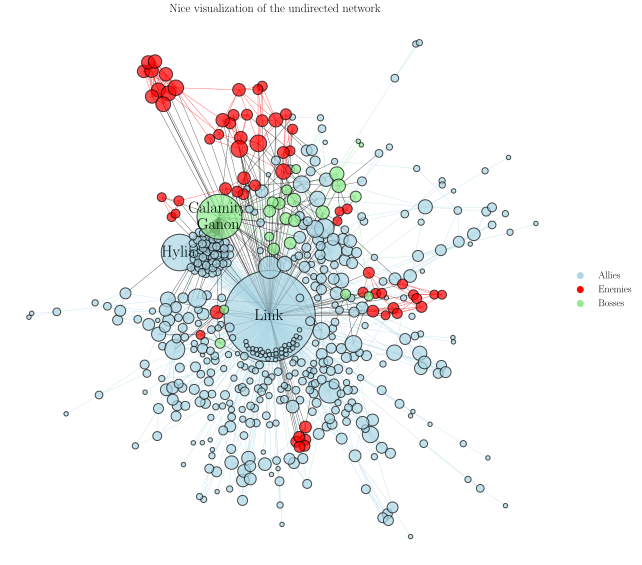

In [16]:
# Set node colours
def colour_node(role):
    if role == "Ally":
        colour = "lightblue"
    elif role == "Boss":
        colour = "lightgreen"
    else: 
        colour = "red"      
    return colour
# Set edge colours
def colour_edges(edge):
    if edge[0] == "Ally" and edge[1] == "Ally":
        colour = "lightblue"
    elif edge[0] == "Enemy" and edge[1] == "Enemy":
        colour = "red"
    elif edge[0] == "Boss" and edge[1] == "Boss":
        colour = "lightgreen"
    else:
        colour = "black"
    return colour

edge_colours = [colour_edges(
    (nx.get_node_attributes(gcc, "Role")[edge[0]], nx.get_node_attributes(gcc, "Role")[edge[1]]))
                for edge in list(gcc.edges(data=True))]
node_colours = [colour_node(nx.get_node_attributes(gcc, "Role")[char]) for char in gcc.nodes()]
node_sizes = [gcc.degree(node) * 20 for node in gcc.nodes()]

# Plot network
fig, ax = plt.subplots(dpi = 800, figsize = (10,10))
opts = {'pos':positions, 'ax':ax, 'alpha': 0.7}

# Nodes
nodes = nx.draw_networkx_nodes(gcc, **opts, node_color=node_colours, node_size=node_sizes, edgecolors = "k")

# Labes for three nodes with highest degree
nx.draw_networkx_labels(gcc, 
                        positions, 
                        {"Link": "Link", 
                         "Calamity Ganon": "Calamity \n Ganon", 
                         "Hylia": "Hylia"}, 
                        font_size=16, 
                        font_color='Black', 
                        font_weight='bold')
# Edges
nx.draw_networkx_edges(gcc, **opts, width = 0.4, edge_color = edge_colours)

# Add legend
ax.scatter([],[], c="lightblue", label=f'Allies')
ax.scatter([],[], c="red", label=f'Enemies')
ax.scatter([],[], c="lightgreen", label='Bosses')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Nice visualization of the undirected network')
plt.axis('off')
plt.show()

<div class="alert alert-warning">

Describe the structure you observe. Can you identify nodes with a privileged position in the network? Do you observe chains of connected nodes? Do you see any interesting group of nodes (can you guess who's involved)?

We can see that the network is very much centralised around *Link* that both connects with fellow Allies, Enemies and Bosses. Likewise we also see that *Calamity Ganon*, the Great King of Evil, also plays an important role as Link's main enemy. However, except for Link there is relatively few links across roles (here coloured black) suggesting that roles are well predictive of communities.

<a id='part2'></a>
# Part 2: Word-clouds
<div class="alert alert-warning">


Create your own version of the word-clouds (from lecture 7). For this exercise we assume you know how to download and clean text from the ZeldaWiki pages.

Here's what you need to do:
> * Create a word-cloud for each race of the [five champions of Hyrule](https://zelda.fandom.com/wiki/Champions) (i.e. Hylian, Zora, Goron, Gerudo, and Rito) according to either TC-IDF. Feel free to make it as fancy as you like. Explain your process and comment on your results.

### Our preprocessing steps briefly explained
The following is the function we used to preprocess our text:

```python
def process_text(character_page:str, characters:List[str],
                 include_bigrams=False)->List[str]:
    """
    Preprocessing of a Zelda page text.
    args:
        character_page(str): string containing the character description from wiki
        character_list(list): list containing all the character names to be removed from page
        include_bigrams(bool): if the final token list should also include bigrams
    returns:
        list of lemmatized tokens
    """
    #Sort the list longest names first
    #Ensures Longest names are deleted first so e.g.
    #"ami" is not deleted from the name "calamity"
    characters.sort(key=len, reverse=True)
    
    #Remove text after nomenclature
    character_page = character_page.split('== Nomenclature ==')[0]
    #Remove names (also plurals)
    for name in characters:
        character_page = re.sub(name, '', character_page)
        character_page = re.sub(name+"'s", '', character_page)
    
    #Remove special characters, punctuation and lowercase
    character_page = character_page.lower()
    character_page = character_page.translate(str.maketrans('', '', string.punctuation)) 
    character_page = re.sub(r'/\\/g',"", character_page)
    character_page = re.sub(r'=+(.*?)=+', '', character_page)
    #Remove the sneaky long hyphen
    character_page = character_page.replace('—','')
    #Remove stopwords, tokenize, lemmatize and remove words shorter than 2 chars
    tokens = [lemmatizer.lemmatize(w) for w in tokenizer.tokenize(character_page) 
              if w not in stop_words and len(w) > 2]
    #Include bigrams
    if include_bigrams:
        tokens += ['_'.join(w) for w in nltk.bigrams(tokens)]
    
    return tokens
```

In summarization, we lowercase and remove character names. We then remove non-alphanumeric characters as well as a long hyphen. After this, we remove stopwords, tokenize, lemmatize and remove words under two characters in length. We run the function twice setting the `include_bigrams` argument to True which initiates the if-statement, creating bigrams for each document as well. The function is then applied at row level which will return two new columns: one for preprocessed text and another for bigrams. 


In [17]:
# grouping by race and create docs
race_grouped = zelda_df.groupby('Race').agg({'Processed_txt': 'sum', 'Processed_txt_bigrams': 'sum',})
race_grouped = race_grouped.loc[race_grouped.index.isin(['Hylian', 'Zora', 'Goron', 'Gerudo', 'Rito'])]
race_docs = race_grouped['Processed_txt'].tolist()
race_docs_bigrams = race_grouped['Processed_txt_bigrams'].tolist()

In [18]:
# function to get vocab and TC-IDF
def create_dfm(docs:List[List], min_df:int=0, 
               max_df:int=np.inf, tf=False, idf=False, 
               return_vocab=False)->np.array:
    """
    Creates document-feature matrix of size N (docs) x K (vocab size).
    args:
        docs(list[list]): a list of documents where a document is a list of tokens.
        max_df(int): maximum freq allowed for a token in a document
        min_df(int): minimum freq required for a token in a document
        tf(bool): calculate term frequency. Otherwise just raw counts.
        idf(bool): calculate the iverse document frequency (idf)
    returns:
        dfm(np.array): the NxK dfm
        vocab(list): vocab of unique tokens (optional)
    """
    #Remove very common or uncommon words
    if min_df != 0 or max_df != np.inf:
        temp = []
        for doc in docs:
            word_freq = Counter(doc)
            temp.append([w for w in doc if word_freq[w] >= min_df and 
                                           word_freq[w] <= max_df])
        docs = temp
        
    #Build the vocabulary and create index for each token
    vocab = list(set([w for doc in docs for w in doc]))
    vocab_size = len(vocab)
    tok2idx = {w:i for i,w in enumerate(vocab)}
    doc_n = len(docs)
    #Instantiate the dfm and add counts
    dfm = np.zeros([doc_n, vocab_size])
    for i,toks in enumerate(docs):
        for tok in toks:
            tok_idx = tok2idx[tok]
            dfm[i, tok_idx] += 1
    
    #Calculate tf and idf
    if tf:
        dfm = dfm / dfm.sum(axis = 1)[:, None]
    if idf:
        idf = np.sign(dfm)
        for i in range(doc_n):
            idf[i] = np.log((doc_n / idf.sum(axis = 0)))
        dfm *= idf
    
    if return_vocab:
        return dfm, vocab
    else:
        return dfm

In [19]:
# creating a TC-IDF for all champions
tcidf_bigrams, vocab = create_dfm(race_docs_bigrams, idf = True, min_df=2, return_vocab=True) 
tcidf, vocab = create_dfm(race_docs, idf = True, min_df=2, return_vocab=True) 
print(f'tc-idf with only unigrams vocab size: {tcidf.shape[1]}. Without removing infrequent words: {create_dfm(race_docs).shape[1]}')
print(f'tc-idf including bigrams vocab size: {tcidf_bigrams.shape[1]}. Without removing infrequent words: {create_dfm(race_docs_bigrams).shape[1]}')

tc-idf with only unigrams vocab size: 3096. Without removing infrequent words: 5928
tc-idf including bigrams vocab size: 6788. Without removing infrequent words: 42351


In [20]:
mask = np.array(Image.open('link_mask.png')) #YOU CAN UNCOMMENT IF YOU WANT FOR NORMAL WC :)
# function to generate a wordcloud for each champion
def create_wordcloud(dfm:np.array, vocab:list, plot_title:list, 
                     scaling:int=1, ncols=5, nrows = 1)->None:
    tc_idf_wcscale = dfm * scaling
    tc_idf_wcscale = tc_idf_wcscale.astype(int)
    fig, axs = plt.subplots(ncols= ncols, nrows = nrows, dpi = 500, figsize = (15,15))
    # return axs 
    for i in range(tc_idf_wcscale.shape[0]):
        wc_str = ''
        for w, tcidf in zip(vocab, tc_idf_wcscale[i,:]):
            wc_str += (w + ' ') * tcidf
        if mask is not None:
            wc = WordCloud(collocations=False,  background_color = 'white', mask=mask).generate_from_text(wc_str)
        else:
            wc = WordCloud(collocations=False,  background_color = 'white').generate_from_text(wc_str)
        axs.flat[i].imshow(wc, interpolation='bilinear')
        axs.flat[i].set_title(plot_title[i])
        axs.flat[i].set_xticks([])
        axs.flat[i].set_yticks([])
    plt.tight_layout()
    plt.show()

In [21]:
create_wordcloud(tcidf, vocab, plot_title=race_grouped.index)
create_wordcloud(tcidf_bigrams, vocab, plot_title=race_grouped.index)

### Reflections about process and results

**TC-IDF:**
First of all, we joined all documents for each of the five champions. We then created a Term Count - Inverse Document Frequency (TC-IDF). The TC is used to determine how many times a given word appears in a document. The IDF determines how common or uncommon a word is among all documents. Combined we find the importance of a term for a given document. Lastly, we also choose to remove words that occur less than two times in a given document. This serves two purposes (1) it decreases the dimensionality of the data which is rather big, especially after including bigrams. (2) such infrequent words are unlikely to carry much meaning for the race.

We took our TC-IDF and made an new string containing each word timed it's corresponding value (or nearest integer). Each word was thus repeated according to its score. This provides us with a word-based string representation of the TC-IDF for each champion race. 

**Word Clouds:**
We output 10 wordclouds; 2 per champion race (one unigram and one including bigrams), which showcase the most important words.

Common (and expected) for all word clouds except 'Hylian' is that each race is in the center of their own word cloud.
In the Hylian word cloud, words worth noticing are 'horse' which occurs 244 times in the Hylian-documents and therefore dominates the cloud. Hylians often travel by horse and also lives in villages which explains the pressence of 'village'. For the bi-gram wordclouds, not many of the bigrams are present. However we do see 'divine_beast' which relates to mechanical animals aiding the hero and princess or 'gerudo_town' which is a location. The bigrams are thus useful for finding features of sets of two adjacent words from a given text. 

Overall the wordclouds can be used for text exploration by visualizing possible clues for simple text analysis. It might also reveal missteps in preprocessing as well as possible further preprocessing steps. We could for instance remove words as 'character' or 'breath' as these are repeated often but don't carry much meaning. 

# Part 3: Communities and TF-IDF
<a id='part3'></a>

<div class="alert alert-warning">
Find communities and compute their associated TF-IDF (from lecture 7 and 8).

Here's what you need to do:
> * Explain the Louvain algorithm and how it finds communities in a newtork.
> * Explain how you chose to identify the communities: Which algorithm did you use? (if you did not use the Louvain method, explain how the method you have used works) 
> * Comment your results:
>   * How many communities did you find in total?
>   * Compute the value of modularity with the partition created by the algorithm.
>   * Plot the distribution of community sizes.
> * For the 5 largest communities, create TF-IDF based rankings of words in each community. 
>   * There are many ways to calculate TF-IDF, explain how you've done it and motivate your choices.
>   * List the 5 top words for each community according to TF.
>   * List the 5 top words for each community accourding to TF-IDF. Are these words more descriptive of the community than just the TF? Justify your answer.

The Louvain is a community detection algorithm that tries to maximize the modularity of the network by assigning nodes to communities. To understand how it works, let us first consider what modularity is. The modularity prescribes how well the network can be partitioned into communities and is calculated as (eq. 9.12 in (Barabási 2016)):

$$
M = \sum^{n_c}_{c=1}\left[\frac{L_c}{L}-\left(\frac{k_c}{2L}\right)^{2}\right]
$$

where $n_c$ are the communities, $L_c$ are the number of links and $k_c$ the total degree of nodes in $c$. The *maximal modularity hypothesis* states that
> *For a given network the partition with maximum modularity corresponds to the optimal community structure (Barabási, 2016).*

On this basis the Louvain algorithm tries find the communities that maximize $M$ by the following two steps: 
1. First it assigns each node to its own communities, i.e. there are as many communities as nodes. Next, for each node $i$ we evaluate if by assigning it to one of its neighbours $j$ communities the change in modularity  $\Delta M$ is positive. Node $i$ then moves to the community of the neighbor that yields the highest positive change in $\Delta M$. This is repeated for all nodes until no further increase can be made.
2. In the second step, the algorithm creates a "super graph", that is each community is condensed into one node where the edges are now weighted by the total number of links going from one community to the other in the original network. Having done this, we rerun the first step on the "super graph". 
The steps are done iteratively meaning the algorithm generates a hierarchy of clusters that could be viewed as a dendrogram.

To solve the task we use the giant connected component of the undirected network created in part 1.

The Louvain algorithm found 19 communities
Modularity of network: 0.578
Largest community consists of 125 nodes
Smallest community consists of 3 nodes
Mean community size 28.158 nodes


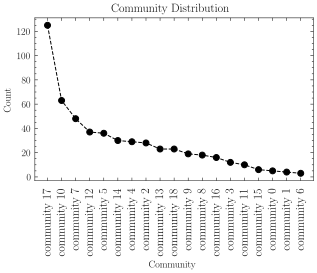

In [22]:
#Get Louvain partitions
partition = community.best_partition(gcc)
community_dist = Counter(partition.values())

print(f'The Louvain algorithm found {len(set(partition.values()))} communities')
print(f'Modularity of network: {np.round(community.modularity(partition,gcc), 4)}')
print(f'Largest community consists of {max(community_dist.values())} nodes')
print(f'Smallest community consists of {min(community_dist.values())} nodes')
print(f'Mean community size {np.round(np.mean(list(community_dist.values())),3)} nodes')


#Plot distribution
x = ['community '+str(x) for x,y in community_dist.most_common()]
y = [y for x,y in community_dist.most_common()]
fig, ax = plt.subplots(dpi = 350, figsize=(5,3))
ax.plot(x, y, 'ko--')
ax.set_title('Community Distribution')
ax.set_ylabel('Count')
ax.set_xlabel('Community')
ax.tick_params(axis='x', which='minor', bottom=False, top=False)
plt.xticks(rotation = 90, size=12)
plt.show()

As can be seen from the results above the Louvain algorithm found $21$ communities and the modularity of the network is approximately $0.57$. The positive modularity score indicates that the network contains a greater community structure than we would expect from a random network. Moreover, the distribution of nodes in each community show that the size of the community varies with the largest community consisting of $117$ nodes, the smallest by $3$ nodes and the mean being $26.75$ nodes. The exact number of communities and modularity must be interpreted with caution however, as can be seen from the plot "Distribution of communities" below these numbers vary across *monte-carlo experiments*. As can be seen the standard deviation for modularity is actually very low, while the amount of communities range from 16-24. This suggests that there are many different partitions that lead to a similarly good modularity - highlighting both the challenge of algorithmically creating communities and the potential pitfalls of interpreting the partitions as True. *P.s. Please note that this also means that the numbers in the text might differ from what you see if the code is re-run*

  0%|          | 0/2000 [00:00<?, ?it/s]

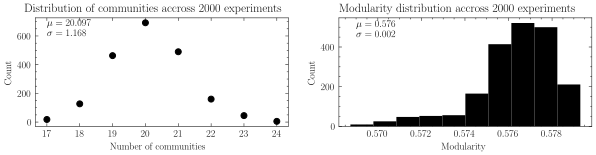

In [23]:
N_TRIES = 2000
n_communities = []
modularities  = []
for n in tqdm(range(N_TRIES)):
    part = community.best_partition(gcc)
    n_communities.append(len(set(part.values())))
    modularities.append(community.modularity(part,gcc))
com_dist = Counter(n_communities)
mod_dist = Counter(modularities)

fig, axs = plt.subplots(ncols = 2, dpi = 300, figsize=(10,2))
axs[0].plot(com_dist.keys(), com_dist.values(), 'ko')
axs[0].set_xlabel('Number of communities')
axs[0].set_ylabel('Count')
axs[0].annotate(f'$ \mu ={np.round(np.mean(n_communities),3)}$ \n $\sigma = {np.round(np.std(n_communities),3)}$',xy=(17, 600))
axs[0].set_title(f'Distribution of communities accross {N_TRIES} experiments')
axs[0].tick_params(axis='x', which='minor', bottom=False, top=False)
axs[1].hist(modularities, color = 'k')
axs[1].set_xlabel('Modularity')
axs[1].set_ylabel('Count')
axs[1].annotate(f'$ \mu ={np.round(np.mean(modularities),3)}$ \n $\sigma = {np.round(np.std(modularities),3)}$',xy=(0.569, 450))
axs[1].set_title(f'Modularity distribution accross {N_TRIES} experiments')
plt.show()

To analyze the communities further we plot the network below, coloring the nodes corresponding to their community and scaling by their degree. Some interesting patterns can be found, for example the second largest community (10) seems to exhibit high cohesions while other communities are a bit more loosely knit.

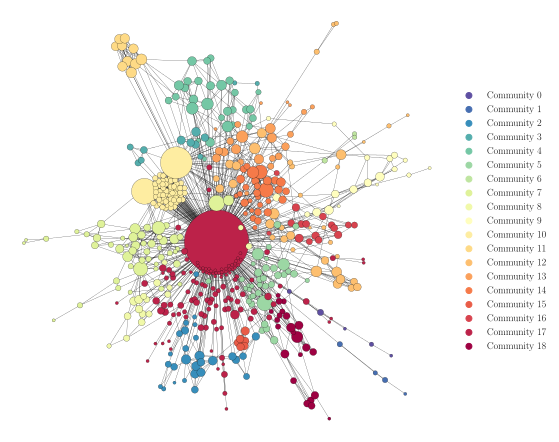

In [24]:
#Get colors and create color map
colors = list(partition.values())
degree = np.array([d[1] for d in gcc.degree])
cmap=plt.cm.Spectral_r
maxval = np.max(colors)

#Draw graph (Using positions from before)
fig, ax = plt.subplots(dpi = 400, figsize = (8,8))
opts = {'pos':positions,
        'ax':ax,
        'node_size':degree*10}
for v in set(colors):
    ax.scatter([],[], c=[cmap(v/maxval)], label=f'Community {v}')
nodes = nx.draw_networkx_nodes(gcc, **opts, linewidths=0.2,
                               node_color=[cmap(v/maxval) for v in colors])
nodes.set_edgecolor('k')
nx.draw_networkx_edges(gcc, **opts, width = 0.2)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.axis('off')
plt.show()

Below we create two separate document feature matrices. One which is based on the term frequencies and the other which is based on the term-frequency (tf) inverse-document frequency (tf-idf). Both are calculated with the function defined earlier called `create_dfm()`. Following the [wikipedia page](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) we calculate the tf as:

$$
\operatorname{tf}(t, d)=\frac{f_{t, d}}{\sum_{t^{\prime} \in d} f_{t^{\prime}, d}}
$$
where $f_{t,d}$ is the frequency of the term $t$ in document $d$ standardized over all terms $\sum_{t^{\prime} \in d} f_{t^{\prime}, d}$. The idf part is calculated as 
$$
\operatorname{idf}(t, D)=\log \frac{N}{|\{d \in D: t \in d\}|}
$$
Where $N$ is the amount of document and $|\{d \in D: t \in d\}|$ how many times a term $t$ occurs across documents, i.e. the $\text{idf_t}=0$ if $t$ is present in all documents, meaning that the term is completely shut down for the corpus. For this part the numpy method `np.sign()` is very useful for our implementation.
so the tf-idf becomes $\operatorname{tfidf}(t, d, D)=\operatorname{tf}(t, d) \cdot \operatorname{idf}(t, D)$. As before, we have chosen to include both unigrams and bigrams. Moreover, we remove words that only occur once in a document to reduce the dimensionality and potential noise (words only used once are unlikely to carry a lot of meaning for that group) from the feature matrix.

In [25]:
#Add the corresponding community to each character in the Data frame
communites = []
obs = namedtuple('Obs', 'Name Louvain_Community')
for n in zelda_df['Name']:
    try:
        com = 'community_'+str(partition[n])
    except:
        com = np.nan
    communites.append(obs(n, com))
    
zelda_df = pd.merge(zelda_df, pd.DataFrame(communites), on='Name')

#Get top6 communities
top6 = ['community_'+str(c[0]) for c in community_dist.most_common(6)]
#Subset data on top5 communities and groupby community. Extract the bigrams.
top6_df = zelda_df.loc[zelda_df['Louvain_Community']\
                  .isin(top6)].groupby('Louvain_Community')\
                  .agg({'Processed_txt':'sum',
                        'Processed_txt_bigrams':'sum'})

bigrams = top6_df['Processed_txt_bigrams'].tolist()

#Create the document term frequency matrices for unigrams and bigrams
bigrams_tfidf, bigrams_vocab = create_dfm(bigrams, tf=True, idf=True, return_vocab=True, min_df=2)
bigrams_tf = create_dfm(bigrams, tf=True,  min_df=2)
#Put into dataframes with vocab as colnames and community as index
tfidf_df = pd.DataFrame(bigrams_tfidf, columns=bigrams_vocab, index = top6_df.index)
tf_df = pd.DataFrame(bigrams_tf, columns=bigrams_vocab, index = top6_df.index)
print(f'The document-feature matrices have {tf_df.shape[0]} documents and {tf_df.shape[1]} tokens in the vocabulary')
tfidf_df

The document-feature matrices have 6 documents and 5584 tokens in the vocabulary


monk_reward  accident  minish_legend  teach_young  \
Louvain_Community                                                      
community_10          0.001226  0.000000       0.000000     0.000000   
community_12          0.000000  0.000000       0.000000     0.000000   
community_14          0.000000  0.000000       0.000000     0.000000   
community_17          0.000000  0.000042       0.000076     0.000042   
community_5           0.000000  0.000000       0.000000     0.000000   
community_7           0.000000  0.000000       0.000164     0.000000   

                      seems  sheikah_tribe  farmer_pitchfork  drop_shard  \
Louvain_Community                                                          
community_10       0.000000       0.000000          0.000000    0.000000   
community_12       0.000000       0.000000          0.000000    0.000000   
community_14       0.000000       0.000000          0.000000    0.000000   
community_17       0.000076       0.000000          0.000042    0.000000   
community_5        0.000000       0.000000          0.000000    0.000106   
community_7        0.000191       0.000215          0.000000    0.000000   

                    without  health_reduced  ...  enters_shrine  \
Louvain_Community                            ...                  
community_10       0.000000        0.000000  ...       0.012461   
community_12       0.000000        0.000000  ...       0.000000   
community_14       0.000430        0.000000  ...       0.000000   
community_17       0.000677        0.000000  ...       0.000000   
community_5        0.000829        0.000000  ...       0.000000   
community_7        0.000609        0.000033  ...       0.000000   

                   older_brother  great_flood  trivia_leaf  horse_noting  \
Louvain_Community                                                          
community_10            0.000000      0.00000     0.000000      0.000000   
community_12            0.000000      0.00000     0.000000      0.000000   
community_14            0.000000      0.00000     0.000000      0.000000   
community_17            0.000042      0.00000     0.000063      0.000042   
community_5             0.000000      0.00000     0.000000      0.000000   
community_7             0.000000      0.00005     0.000000      0.000000   

                   state_belief      pair  part_trial      side  asks_come  
Louvain_Community                                                           
community_10           0.000000  0.000000    0.000000  0.000000   0.000000  
community_12           0.000000  0.000185    0.000000  0.000112   0.000000  
community_14           0.000000  0.000377    0.000000  0.001260   0.000000  
community_17           0.000000  0.000287    0.000000  0.000993   0.000000  
community_5            0.000000  0.000000    0.000000  0.001275   0.000000  
community_7            0.000033  0.000000    0.000033  0.001364   0.000033  

[6 rows x 5584 columns]

Below we plot the most important unigrams and bigrams for the 6 largest communities. First according to the tf-idf and later according to tf. Theoretically, the tf-idf can be a good measure to show words that are descriptive of each community as it also takes into account how common the words are across documents. In other words, high tf-idf words are those that carry the most discriminative power between communities. However, it is also prone to pick up noise e.g. that is not necessarily descriptive of the community in the case when the tf is low but the idf very high. To make truly substantive interpretations we deem domain knowledge to be crucial - something which we in our group completely lack. For the purpose of this assignment, however, some observations can be made. First of all, looking at community $10$ we see much more bigrams in the tf-idf and tf distribution. This makes sense as the likelihood of a combination of words is a joint probability and therefore likely decreases the likelihood of being present in several documents. Moreover, the rank-order correlation between the top tf and tf-idf tokens is still relatively high. This suggests that tokens that discriminate between communities also tend to be among the most common within a community and therefore likely rather descriptive. Lastly, performing this kind of analysis revealed problems in the text preprocessing. For example, the character "Ami" messed up the removal of "Calamity Ganon" by leaving the token "Calty" which showed up in the tf and tf-idf. To deal with this we went back to the preprocessing and ordered the list of names to be removed by the length of the name (from longest to shortest) which should be more robust. 

In [26]:
def plot_topn(df:pd.DataFrame, n:int=20, idf=False)->None:
        
    fig, axs = plt.subplots(nrows = 2, ncols=3, 
                            figsize = (10,5), dpi = 300)
    axs = axs.flat
    for i, row in enumerate(df.iterrows()):
        d = row[1].nlargest(n).to_dict()
        x = [n.replace('_', ' ') for n in d.keys()]
        y = d.values()
        axs[i].plot(x,y, 'ko')
        axs[i].set_title(df.index[i].replace('_', ' ') + f': top {n} words')
        if idf:
            axs[i].set_ylabel('tf\_idf score')
        else:
            axs[i].set_ylabel('tf score')
        axs[i].tick_params(axis='x', rotation=90)
        axs[i].tick_params(axis='x', which='minor', bottom=False, top=False)
    plt.tight_layout()

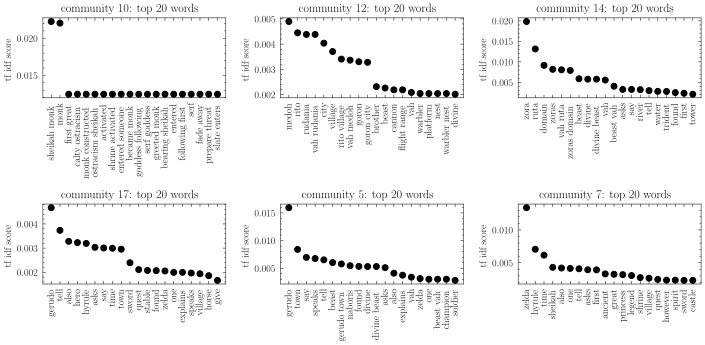

In [27]:
#Plot tf-idf
plot_topn(tfidf_df, idf=True)

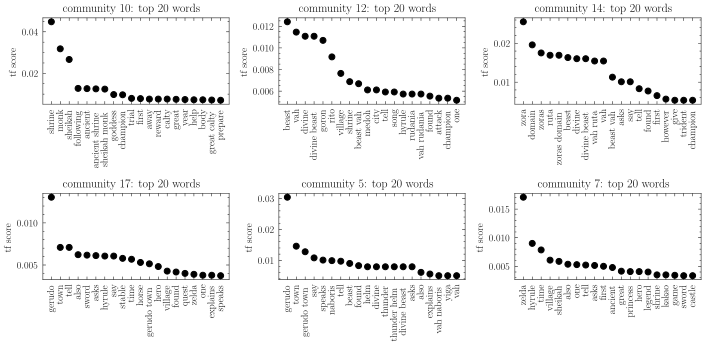

In [28]:
#plot tf
plot_topn(tf_df)

<a id='part4'></a>
# Part 4: Sentiment of communities

<div class="alert alert-warning">
Analyze the sentiment of the communities (lecture 8). Here, we assume that you've successfully identified communities.  More tips & tricks can be found, if you take a look at Lecture 8's exercises.

A couple of additional instructions you will need below:
* We name each community by its three most connected characters.
* Average the average sentiment of the nodes in each community to find a community level sentiment.

Here's what you need to do (repeat these steps and report your results for **both LabMT and VADER**):
> * Calculate and store sentiment for every character
> * Create a histogram of all character's associated sentiments.
> * What are the 10 characters with happiest and saddest pages?

Below, we calculate the `VADER` and `LabMT` sentiment score for each character dialog. Next we plot the characters with the 20 highest and 20 lowest scores, with the horizontal black line separating the two.  For Labmt we append the sentiment score 5 for each word not present in the dictionary. Since this is the theoretical mean of the score, we interpret it as *Neutral*. Although the prompt refers to this as happiness and sadness, we want to point out that it is by no means given that this is what the sentiment score actually measures. Without further analysing the words driving the scores we think it is better to think of it as relative positivity and negativity. For example, curse words are generally coded with a low sentiment score and does not necessarily imply sadness but might just as well relate to hatefulness. 

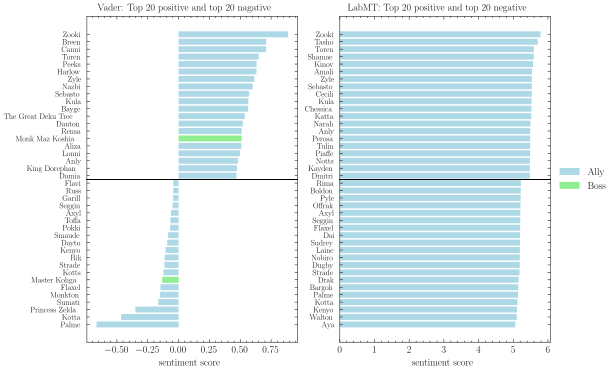

In [29]:
labmt_dict = labmt.set_index('word').to_dict()['happiness_average']
TOP_N = 20

tokenizer = nltk.WordPunctTokenizer()
lemmatizer = nltk.WordNetLemmatizer()

analyzer = SentimentIntensityAnalyzer()
color_map = {'Ally':'lightblue', 
             'Enemy':'red',
             'Boss':'lightgreen'}
#Calculate sentiment
vader_sents = dict()
labmt_sents = dict()
colors = []
for char,diags in diaglogs.items():
    vader_sents[char] = np.mean([analyzer.polarity_scores(sent)['compound'] for sent in diags])
    lbmt_score = []
    for sent in diags:
        for w in tokenizer.tokenize(sent):
            tok = lemmatizer.lemmatize(w).lower()
            try:
                lbmt_score.append(labmt_dict[tok])
            except:
                lbmt_score.append(5) #Append the theo
    labmt_sents[char] = np.mean(lbmt_score)    
    colors.append(zelda_df.loc[zelda_df['Name'] == char]['Role'].tolist()[0])

#Get top sentiments for each method
sorted_vader = sorted(vader_sents.items(), key=lambda item: item[1])
sorted_labmt = sorted(labmt_sents.items(), key=lambda item: item[1])
top_sents = {'vader': sorted_vader[:TOP_N] + sorted_vader[-TOP_N:],
             'labmt': sorted_labmt[:TOP_N] + sorted_labmt[-TOP_N:]}
 
def legend_without_duplicate_labels(ax, pos=(0,0.5)):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique),loc='center left', bbox_to_anchor=pos)
 
fig, axs = plt.subplots(ncols = 2, figsize = (6,6))

for y,x in top_sents['vader']:
    role = zelda_df.loc[zelda_df['Name']==y]['Role'].tolist()[0]
    axs[0].barh(y, x, color = color_map[role], label = role)
    axs[0].tick_params(axis="y", labelsize=8)
    axs[0].set_xlabel('sentiment score')
    axs[0].axhline(TOP_N-0.5, color='k', linewidth=0.5)
    axs[0].set_title(f'Vader: Top {TOP_N} positive and top {TOP_N} nagative', size = 10)
    axs[0].tick_params(axis='y', which='minor', left=False, right=False)

for y,x in top_sents['labmt']:
    role = zelda_df.loc[zelda_df['Name']==y]['Role'].tolist()[0]
    axs[1].barh(y, x, color = color_map[role], label = role)
    axs[1].tick_params(axis="y", labelsize=8)
    axs[1].set_xlabel('sentiment score')
    axs[1].axhline(TOP_N-0.5, color='k', linewidth=0.5)
    axs[1].set_title(f'LabMT: Top {TOP_N} positive and top {TOP_N} negative', size = 10)
    axs[1].tick_params(axis='y', which='minor', left=False, right=False)

plt.subplots_adjust(right=1.2)
plt.tight_layout    
legend_without_duplicate_labels(axs[0], pos=(2.2,0.5))
plt.show()

The theoretical range for `vader` character mean sentiment is $[-1,1]$ and $[0,10]$. The two methods for calculating sentiment show quite different results. First of all, the `vader` shows a much higher variation between characters within its range. Moreover, the `LabMT` is only composed of allies while the `Vader` has two bosses and one enemy. We find this surprising, as we would expect enemies and bosses in a video game to use a more negative language than allies. It can also be noted that the most positive character *Zooki* is robust across methods. Below, we also plot the distribution of the sentiment from which we can see that both methods produce distributions that approach a normal with a mean score slightly above the middle of its corresponding range. This suggests that characters, on average, use a positive language. 

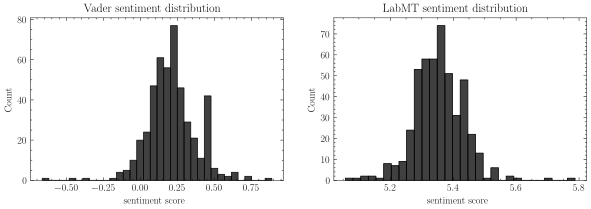

In [30]:
#Plot the distribution of the sentiment
fig, axs = plt.subplots(ncols = 2, dpi = 300, figsize=(10,3))
sns.histplot(list(vader_sents.values()), color = 'k', ax=axs[0])
axs[0].set_xlabel('sentiment score')
axs[0].set_title('Vader sentiment distribution')
sns.histplot(list(labmt_sents.values()), color = 'k', ax = axs[1])
axs[1].set_title('LabMT sentiment distribution')
axs[1].set_xlabel('sentiment score')
plt.show()

As a last step in this part of the analysis we also look at the correlation between the scores produced by the two methods. As can be seen the pearson's $\rho$ indicate a quite strong and positive relationship of approx $0.56$ between the scores. This gives some confidence in the robustness of the two methods. 

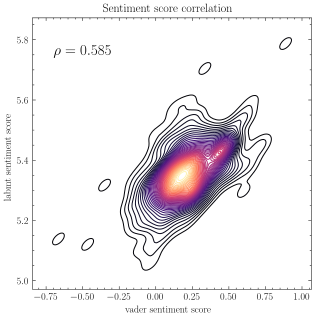

In [31]:
sents_arr = np.array([[v for v in vader_sents.values()], [v for v in labmt_sents.values()]]).T
warnings.filterwarnings("ignore", category=FutureWarning) 
fig, ax = plt.subplots(dpi = 600, figsize = (5,5))
sns.kdeplot(sents_arr[:,0], sents_arr[:,1], fill=False,
           thresh=0, levels=50, ax = ax, cmap='magma')
ax.set_xlabel('vader sentiment score')
ax.set_ylabel('labmt sentiment score')
ax.set_title('Sentiment score correlation')
r = np.round(pearsonr(sents_arr[:,0], sents_arr[:,1])[0],3)
ax.annotate(f'$\\rho ={r}$',xy=(-0.7, 5.75), size=15)
plt.show()

<div class="alert alert-warning">

    
Now, compute the sentiment of communities: 

> * What are the three happiest communities according to the LabMT wordlist approach? What about VADER?
> * What are the three saddest communities according to the LabMT wordlist approach? What about VADER?
> * Create a bar plot showing the average sentiment of each community and add error-bars using the standard deviation for both methods. 
> * Explain the difference between the two methods and compare the results you have obtained above.
> * What is the advantage of using a rule-based method over the dictionary-based approach? 

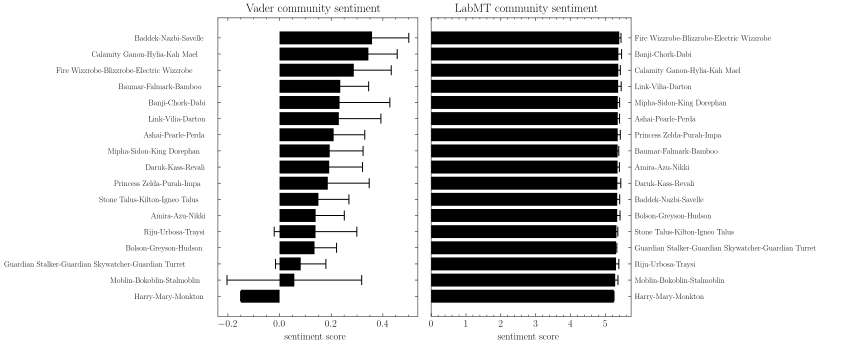

In [32]:
#Get top 3 characters within community
zelda_df['degree'] = zelda_df['In-degree'] + zelda_df['Out-degree']
#Sorry for the this uggly uggly thing
community_names = zelda_df.sort_values(['Louvain_Community', 'degree'], ascending=False)\
                          .groupby('Louvain_Community')\
                          .head(3)\
                          .dropna()\
                          .groupby('Louvain_Community')\
                          .agg({'Name':'-'.join})\
                          .to_dict()['Name']

#Remove parenthesis
community_names = {k:re.sub('\s\((.+?)\)', '', n) for k,n in community_names.items()}
#Calculate sentiment
vader_community = defaultdict(list)
labmt_community = defaultdict(list)
colors = []
for char,diags in diaglogs.items():
    try:
        com = community_names[zelda_df.loc[zelda_df['Name']==char]['Louvain_Community'].tolist()[0]]
    except:
        pass
    vader_community[com].append(np.mean([analyzer.polarity_scores(sent)['compound'] for sent in diags]))
    lbmt_score = []
    for sent in diags:
        for w in tokenizer.tokenize(sent):
            tok = lemmatizer.lemmatize(w).lower()
            try:
                lbmt_score.append(labmt_dict[tok])
            except:
                lbmt_score.append(5)
    labmt_community[com].append(np.mean(lbmt_score))   

#Calculate within community mean
vader_mean = sorted({k: np.mean(v) for (k, v) in vader_community.items()}.items(),
                    key=lambda item: item[1])
labmt_mean = sorted({k: np.mean(v) for (k, v) in labmt_community.items()}.items(), 
                    key=lambda item: item[1])
#Calculate within community std
vader_std = {k: np.std(v) for (k, v) in vader_community.items()} 
labmt_std = {k: np.std(v) for (k, v) in labmt_community.items()}

#Plot the sentiment for communities
fig, axs = plt.subplots(ncols=2, figsize=(12,5))
for y,x in vader_mean:
    axs[0].barh(y, x, color='k', xerr = vader_std[y], 
                ecolor='k', capsize=5)
    axs[0].tick_params(axis="y", labelsize=8)
    axs[0].set_title('Vader community sentiment')
    axs[0].set_xlabel('sentiment score')
    axs[0].tick_params(axis='y', which='minor', left=False, right=False)
    
for y,x in labmt_mean:
    axs[1].barh(y, x, color='k', xerr = labmt_std[y], 
                ecolor='k', capsize=5)
    axs[1].tick_params(axis="y", labelsize=8)
    axs[1].set_title('LabMT community sentiment')
    axs[1].yaxis.set_ticks_position("right")
    axs[1].set_xlabel('sentiment score')
    axs[1].tick_params(axis='y', which='minor', left=False, right=False)

plt.tight_layout()

The two plots above show the mean sentiment and standard deviation for each community found by the Louvain algorithm. Consistent with previous results the `Vader` sentiment has much greater variance both between and within communities. However, both the rank order and relative within variation are fairly similar for both methods. For example, the communities whith Hary-Mary-Monkton and Mobilin-Bokonblin-Stalmoblin are the most negative communities in both cases. Moreover, Mobilin-Bokonblin-Stalmoblin and Riju-Ubosa-Traysi being among the communities with the highest within sentiment variation is also robust across methods. 

Both methods are non-probabilistic and rely on a predefined dictionary where words have been coded on a scale from most negative to most positive. The difference is that `Vader` also standardizes the score across sentences and incorporates rules based on grammatical and syntactical heuristics. For example it will classify the sentence "The food here is GREAT!” to be more positive than “The food here is great!"  (Hutto, C., & Gilbert, E. 2014, May). This has clear advantages as we are able to extract more information from the same text than only relying on a dictionary. It also makes sense from a theoretical view-point as it the score to a higher extent reflects how language is actually used (At least in certain contexts like social media etc.).

# References

* Hutto, C., & Gilbert, E. (2014, May). Vader: A parsimonious rule-based model for sentiment analysis of social media text. In Proceedings of the International AAAI Conference on Web and Social Media (Vol. 8, No. 1).
* Barabási, A. L. (2014). Network science book. Network Science, 625.